In [11]:
import numpy as np
import math
from scipy.optimize import linprog
from abc import ABC
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import pulp as pl

In [2]:
def generate_bit_data(n = 1000): 
    """
    Generate an array of n random bits.
    """
    return np.random.randint(0,2,n)

class Mechanism(ABC): 
    pass

class NoiseMechanism(Mechanism):
    """
    A mechanism whose queries return the true result plus noise generated by noise_generator. 
    noise_generator takes 0 arguments and returns a value of the same type as query
    """

    def __init__(self, dataset, noise_generator):
        self.dataset = dataset
        self.length = len(dataset)   
        self.noise_generator = noise_generator
        
    def get_len(self):
        return self.length
    
    def get_raw_data(self):
        return self.dataset

    def query(self, indices): 
        result = np.sum(self.dataset[indices])
        noise = self.noise_generator()
        return result + noise
    
class LaplaceMechanism(NoiseMechanism):
    """
    A noise mechanism that draws its noise from the Laplace(sensitivity/epsilon) distribution
    """
    def __init__(self, dataset, epsilon, sensitivity=1):
        self.scale = (sensitivity/epsilon)
        noise = lambda : np.random.laplace(loc=0,scale = self.scale, size=None)
        super().__init__(dataset, noise)
    
class GaussianMechanism(NoiseMechanism):
    """
    A noise mechanism that draws its noise from the Normal(2*(sensitivity^2)log(1/25/delta)/(epsilon^2))distribution
    """
    
    def __init__(self, dataset, epsilon, delta, sensitivity = 1):
        self.scale = (2 * (sensitivity ** 2) * math.log(1.25/delta)) / (epsilon ** 2)
        noise_generator = np.random.normal(loc=0, scale=self.scale, size=None)
        super().__init__(dataset, noise_generator)
    
    
def dinur_nissim(mech, epsilon = 0.5, gen_t = lambda n : n * (math.log2(n) ** 2), should_log = False):
    """
    Perform a dinur_nissim attack on the dataset, mediated by mech, a Mechanism object. 
    
    epsilon and t are the two hyperparameters of the attack. gen_t generates int-valued t as a function of n, the size of the dataset.
    
    Wrap all logging behond `should_log`
    """
    
    n = mech.get_len()
    t = int(gen_t(n))

    def generate_query():
        # Generate a random subset of [n] by generating a list of bits and convert to indices
        q_j = np.random.randint(0,2,n)
        indices2 = q_j.nonzero()
        return (q_j, indices2) 
    
    # Make t queries to the mechanism. A_ub and b_ub are respectively the coefficient matrix 
    #   and upper bound for the linear program 
    A_ub = []
    b_ub = []
    for _ in range(int(t)):
        q, indices = generate_query()
        answer = mech.query(indices)
        A_ub.append(q)
        b_ub.append(answer + epsilon)
        A_ub.append(-1 * q)
        b_ub.append(epsilon - answer)
    A_ub = np.vstack(A_ub)
    b_ub = np.array(b_ub)
    # Rounding Phase: round the results of the LP into integers
    
    if(should_log):
        print(f"Solving LP with {len(b_ub)} constraints")
    program_result = linprog(np.zeros(n), np.vstack(A_ub), b_ub, bounds=(0,1))

    if(should_log):    
        print(f"Done w/ LP")
    round_vector = np.vectorize(round, otypes=[int])
    return round_vector(program_result["x"])

# Utilities
def percent_reconstructed(data, results): 
    """
    What percentage of entries in data match those in results.
    """
    n = len(data)
    return 1 - ((np.count_nonzero(data!=results))/n)

class ConstantFunction:
    def __init__(self, start):
        self.current = start
    
    def __call__(self, x):
        return self.current



In [212]:
# Very simple example
# data = generate_bit_data(n=500)
# mech = LaplaceMechanism(data, epsilon=100)
# dinur_nissim(mech, gen_t=lambda n : n)

In [3]:
# Run a set of experiments. See usage below.
def run_experiment(ns, mechanism_class, mech_args, dn_epsilons, t_generators, should_log=True, output_filename = None): 
    
    results_df =  pd.DataFrame(columns=["n", 
                              *list(mech_args[0].keys()), 
                              "dn_epsilon", 
                              "num_queries", 
                              "percent_reconstructed"]) 
    
    def make_entry(mech_arg, n, dn_epsilon, t, pc_reconstructed): 
        res = {x : [mech_arg[x]] for x in mech_arg.keys()}
        res.update (
            {
                "n" : [n],
                "dn_epsilon" : [dn_epsilon],
                "num_queries" : [t],
                "percent_reconstructed" : pc_reconstructed
            }
        )
        return pd.DataFrame.from_dict(res)
 
    total = len(ns)*len(mech_args)*len(dn_epsilons)*len(t_generators)
    if(should_log):
        print(f"Running {total} experiments")
        
    so_far = 0
    for n in ns:
        for mech_arg in mech_args:
            # New dataset and mech for each size/mechanism params pair
            data = generate_bit_data(n=n)
            mech = mechanism_class(data, **mech_arg)
            for dn_epsilon in dn_epsilons: 
                for t_generator in t_generators:
                    result = dinur_nissim(mech, dn_epsilon,t_generator)
                    # Lambdas are hard to log so we log its application. We can probably abstract this better.
                    t = int(t_generator(n))
                    
                    # Append new results 
                    entry = make_entry(mech_arg, n, dn_epsilon, t, percent_reconstructed(data, result))
                    results_df = pd.concat([results_df, entry], ignore_index=True)     
                    so_far += 1
                    if should_log:
                        print(f"Finished {so_far}/{total}")
                        
    if output_filename:
        if should_log:
            printf(f"Writing results to {output_filename}")
        df.to_csv(output_filename, encoding='utf-8', header='true')
    return results_df

def read_results(filename):
    return pd.read_csv (filename, index_col=0)

In [4]:
# General plotting functions
def plot_3d(df, filter_cond, x1, x2, y, labels, title):
    df = filter_cond(df)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.plot_trisurf(df[x1], df[x2], df[y], cmap=cm.jet, linewidth=0.2)
    ax.set_xlabel(labels[0], fontsize=10)
    ax.set_ylabel(labels[1], fontsize=10)
    ax.set_zlabel(labels[2], fontsize=10)
    ax.set_title(title, fontsize=15)
    plt.show()
    
def plot_single_x_multiple_subsets(df, filter_cond, x, y, divide_on, dividers, xlabel, ylabel, legend_formatter, title): 
    fig = plt.figure()
    ax = plt.gca()
    for div in dividers:
        s = df[df[divide_on] == div]
        ax.plot(s[x], s[y], label = legend_formatter(div))
    ax.legend()
    ax.set_title(title, fontsize=15)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

# Some preliminary specific plots

def plot_3d_eps_t(df):
    plot_3d(df, 
            filter_cond = lambda x : x, 
            x1 = "num_queries", 
            x2 = "epsilon", 
            y = "percent_reconstructed",
            labels = ['Num Queries', 'Epsilon', 'Proportion Reconstructed'], 
            title = "Dinur Nissim w/ Laplace Noise, n=1000, dn_epsilon=0.5")

    
def plot_eps_multiple_t(df, ts):
    plot_single_x_multiple_subsets(
        df=df,
        filter_cond = lambda x : x,
        x="epsilon",
        y="percent_reconstructed",
        divide_on="num_queries",
        dividers=ts,
        xlabel = "Epsilon",
        ylabel = "% Reconstructed", 
        legend_formatter = lambda x : f"{x} queries",
        title = "Dinur Nissim w/ Laplace Noise, n = 1000, dn_epsilon = 0.5"
    )

def plot_t_multiple_eps(df, epss):
    plot_single_x_multiple_subsets(
        df=df,
        filter_cond = lambda x : x,
        x="num_queries",
        y="percent_reconstructed",
        divide_on="epsilon",
        dividers=epss,
        xlabel = "# Queries",
        ylabel = "% Reconstructed", 
        legend_formatter = lambda x : f"Epsilon = {x}",
        title = "Dinur Nissim w/ Laplace Noise, n = 1000, dn_epsilon = 0.5"
    )

def plot_both_eps(df):
    plot_3d(df, 
            filter_cond = lambda d : d, 
            x1 = "dn_epsilon", 
            x2 = "epsilon", 
            y = "percent_reconstructed",
            labels = ['Dinur Nissim Epsilon', 'Epsilon', 'Proportion Reconstructed'], 
            title = "Dinur Nissim w/ Laplace Noise, n=1000, dn_epsilon=0.5")


def plot_t_single_eps(df, epss):
    plot_single_x_multiple_subsets(
        df=df,
        filter_cond = lambda x : x,
        x="dn_epsilon",
        y="percent_reconstructed",
        divide_on="epsilon",
        dividers=epss,
        xlabel = "DN Epsilon",
        ylabel = "% Reconstructed", 
        legend_formatter = lambda x : f"Epsilon = {x}",
        title = "Dinur Nissim w/ Laplace Noise, n = 1000"
    )

In [224]:
# Example usage. Essentially runs over the cartesian product of the lists [ns, mech_args, dn_epsilons, t_generators]
test_run_2 = run_experiment(
    ns = [1000], 
    mechanism_class = LaplaceMechanism, 
    mech_args = [{"epsilon": x} for x in [.1*y for y in range(3, 16)]], 
    dn_epsilons=[.5], 
    t_generators=([ConstantFunction(n) for n in [50*y for y in range(8, 14)]]), 
    output_filename="data/laplace_n1000_dne0.5.csv'")

# two_epsilons = run_experiment(
#     ns = [1000], 
#     mechanism_class = LaplaceMechanism, 
#     mech_args = [{"epsilon": x} for x in [.1*y for y in range(7, 11)]], 
#     dn_epsilons=[0.1*x for x in range(1, 10)], 
#     t_generators=([lambda n: n, lambda n: 2*n])
#     output_filename="data/two_epsilons_test.csv'")

Running 78 experiments
Finished 1/78
Finished 2/78
Finished 3/78
Finished 4/78
Finished 5/78
Finished 6/78
Finished 7/78
Finished 8/78
Finished 9/78
Finished 10/78
Finished 11/78
Finished 12/78
Finished 13/78
Finished 14/78
Finished 15/78
Finished 16/78
Finished 17/78
Finished 18/78
Finished 19/78
Finished 20/78
Finished 21/78
Finished 22/78
Finished 23/78
Finished 24/78
Finished 25/78
Finished 26/78
Finished 27/78
Finished 28/78
Finished 29/78
Finished 30/78
Finished 31/78
Finished 32/78
Finished 33/78
Finished 34/78
Finished 35/78
Finished 36/78
Finished 37/78
Finished 38/78
Finished 39/78
Finished 40/78
Finished 41/78
Finished 42/78
Finished 43/78
Finished 44/78
Finished 45/78
Finished 46/78
Finished 47/78
Finished 48/78
Finished 49/78
Finished 50/78
Finished 51/78
Finished 52/78
Finished 53/78
Finished 54/78
Finished 55/78
Finished 56/78
Finished 57/78
Finished 58/78
Finished 59/78
Finished 60/78
Finished 61/78
Finished 62/78
Finished 63/78
Finished 64/78
Finished 65/78
Finished 66

NameError: name 'printf' is not defined

In [218]:
# Read in the data from the above examples
test_run = read_results('data/laplace_n1000_dne0.5.csv')
two_epsilons = read_results('data/two_epsilons_test.csv')

In [223]:
# Now just make some demo plots
test_run

,n,epsilon,dn_epsilon,num_queries,percent_reconstructed
0,1000,0.3,0.5,400,0.698
1,1000,0.3,0.5,450,0.720
2,1000,0.3,0.5,500,0.717
3,1000,0.3,0.5,550,0.730
4,1000,0.3,0.5,600,0.755
...,...,...,...,...,...
73,1000,1.5,0.5,450,0.825
74,1000,1.5,0.5,500,0.869
75,1000,1.5,0.5,550,0.952
76,1000,1.5,0.5,600,0.995


/var/folders/mk/ydf2207j325_0l9ph1swkbzc0000gq/T/ipykernel_52466/3532059477.py:5: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


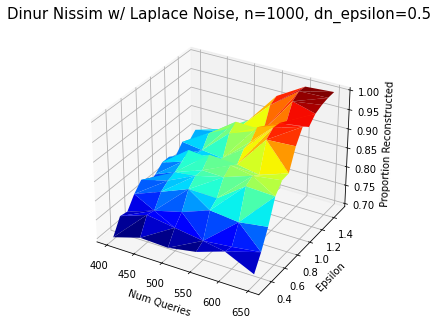

In [220]:
plot_3d_eps_t(r)

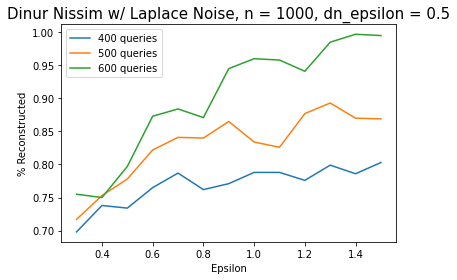

In [221]:
plot_eps_multiple_t(r, ts = [400, 500,  600])

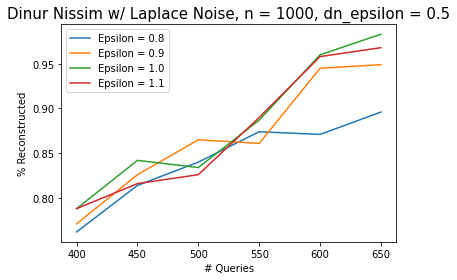

In [222]:
plot_t_multiple_eps(r, epss=[.1*y for y in range(8, 12)])

/var/folders/mk/ydf2207j325_0l9ph1swkbzc0000gq/T/ipykernel_52466/3532059477.py:5: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


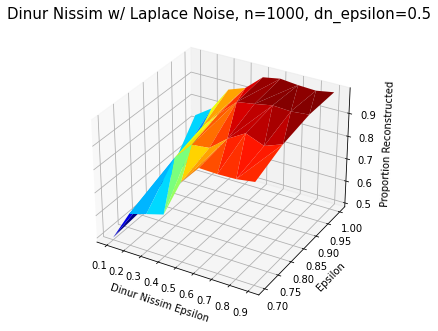

In [206]:
plot_both_eps(two_epsilons[two_epsilons["num_queries"] == 1000])

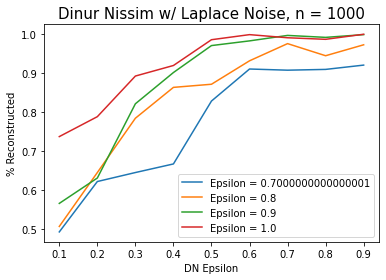

In [207]:
plot_t_single_eps(two_epsilons[two_epsilons.num_queries == 1000], [.1*y for y in range(7, 11)])

In [6]:
def cn19(mech, k = 1, gen_t = lambda n : n * (math.log2(n) ** 2), should_log = False):
    """
    Performs the attack from CN19 on the dataset, mediated by mech, a Mechanism object. 
    
    t is the two hyperparameters of the attack. 
    
    gen_t generates int-valued t as a function of n, the size of the dataset.
    
    k is the number such that the data take values in [0...k].
    
    Wrap all logging behond `should_log`
    """
    
    n = mech.get_len()
    t = int(gen_t(n))

    def generate_query():
        # Generate a random subset of [n] by generating a list of bits and convert to indices
        q_j = np.random.randint(0,2,n)
        indices2 = q_j.nonzero()
        return (q_j, indices2) 
    
    # Set up the LP using pulp 
    lp = pl.LpProblem("Decoding", pl.LpMinimize)
    
    # x_i contains the i'th entry in the candidate database 
    xs = [pl.LpVariable(str(i), 0, k) for i in range(n)]
    # abs_e_qs stores the absolute values of the e_q, the difference between the answer and q(x')
    abs_e_qs = []
    # Generate variables based on the query 
    for i in range(t):
        q, indices = generate_query()
        answer = mech.query(indices)
        # Get q(x') by evaluating our query on the candidate database 
        q_x = [(xs[j], q[j]) for j in range(n)]
        abs_e_q = pl.LpVariable(("abs_e_q" + str(i)))
        abs_e_qs.append(abs_e_q)
        # Add a variable to represent the sum of a_q - q(x') 
        temp_sum = pl.LpVariable("temp_sum" + str(i))
        # Add the constraints such that abs_e_qs will become the absolute value of a_q - q(x')
        lp += (temp_sum == (answer - pl.LpAffineExpression(q_x)))
        lp += (abs_e_q >= temp_sum)
        lp += (abs_e_q >= -temp_sum)
        
    # We want our objective to be the sum of |e_q| over all queries
    lp += pl.lpSum(abs_e_qs)
    
    if(should_log):
        print(f"Solving LP with {len(b_ub)} constraints")
    status = lp.solve()

    if(should_log):    
        print(f"Done w/ LP")
    # Return the rounded values
    return [round(pl.value(x)) for x in xs]
        
        
    


In [10]:
def generate_data(k, n = 1000): 
    """
    Generate an array of n random numbers in [0...k].
    """
    return np.random.randint(0,k+1,n)


data = generate_data(k=5, n=10)
mech = LaplaceMechanism(data, epsilon=1)
percent_reconstructed(cn19(mech, k=5, gen_t=lambda n : 1000), data)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/macuser/miniconda/envs/cs187/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/mk/ydf2207j325_0l9ph1swkbzc0000gq/T/413798ce1a5c4dcda2869231343a6b73-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/mk/ydf2207j325_0l9ph1swkbzc0000gq/T/413798ce1a5c4dcda2869231343a6b73-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 3005 COLUMNS
At line 19006 RHS
At line 22007 BOUNDS
At line 24018 ENDATA
Problem MODEL has 3000 rows, 2010 columns and 9955 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 2369 (-631) rows, 1381 (-629) columns and 10565 (610) elements
Perturbing problem by 0.001% of 1 - largest nonzero change 5.5448568e-05 ( 0.0055448568%) - largest zero change 5.5287406e-05
0  Obj -10191.708 Primal inf 34927.872 (1662)
122  Obj -10167.369 Primal inf 26494.08

1.0

In [ ]:
"""
Data Generation Parameters
    What distribution: uniform, gaussian
    Data type: bit arrays, int arrays

DP Parameters:
    Laplace: Epsilon and sensitivity of the query function (depends on the data / attack)
    Gaussian: Same as above + delta

Attack Parameters
    Dinur Nissim: 
        function t(n) (# of queries)
        dn_epsilon
    
    CN19: 
        t(n) number of queries 
        
Bit arrays + Laplace
    fix dn_epsilon, vary # queries and laplace epsilon
    


1. Dinur Nissim + No DP 
    instantly solves

2. Laplace vs. Gaussian 
    # of queries needed queries needed to reconstrinct 95% or a few %s vs. epsilon; fix delta or try a couple deltas
        n 1.1n 1.2n etc 

3. When you noise, how much usefulness lost? 
    Fix everything (most queries from prev experiment) except amount of noise and plot. Plot two axes of epsilon vs both % reconstructed and accuracy maintained

4. CN19 Attack
    With bits, just see how much the # of queries decreases vs dinur nissim for a few different Ns. Keep epsilon as what we said was "most optimal" 

5. CN19 With Integers
    Normal vs. Uniform vs. Some bimodal/multimodal distributions 
    
6. Michael w/ a real world attack 

7. Michael w/ a membership attack
    
    
    
We have shown that the success of reconstruction attacks in the real world is contingent on a variety of parameters of both the mechanism by which the attack is carried out 
and the mechanisms used to protect the data. 

""" 


